In [0]:
import numpy as np

import sys
from google.colab import drive

import matplotlib.pyplot as plt

In [2]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [0]:
sys.path.append("./drive/My Drive/Rosneft Seismic/models/modules_rus")

In [0]:
x_train = np.load("./drive/My Drive/Rosneft Seismic/train/x_train.npy")
y_train = np.load("./drive/My Drive/Rosneft Seismic/train/y_train.npy")

In [0]:
def mask_border(mask):
    rows, cols = mask.shape
    border = np.zeros_like(mask)

    for j in range(cols):
        i_up = rows - 1
        i_down = 0
        for i in range(rows):
            if mask[i, j] > 0:
                if i_up > i:
                    i_up = i
                if i_down < i:
                    i_down = i

        assert(i_down - i_up < rows - 1)
        if i_down - i_up >= 3:
            border[i_up, j] = 1
            border[i_up + 1, j] = 1
            border[i_down - 1, j] = 1
            border[i_down, j] = 1
        elif i_down - i_up == 2:
            border[i_up, j] = 1
            border[i_up + 1, j] = 1
            border[i_down, j] = 1
        elif i_down - i_up == 1:
            border[i_up, j] = 1
            border[i_down, j] = 1
        else:
            border[i_up, j] = 1

    return border

In [0]:
y_train_0 = np.array([
    np.concatenate(
        (
            y_train[i, :, :, 0][:, :, np.newaxis],
            mask_border(y_train[i, :, :, 0])[:, :, np.newaxis]
         ),
         axis=2)
    for i in range(y_train.shape[0])
])

In [45]:
def dice(x, y, eps=1.0):
    x_f = K.flatten(x)
    y_f = K.flatten(y)
    return (2 * K.sum(x_f * y_f) + eps) / (K.sum(x_f) + K.sum(y_f) + eps)

def dice_coef(y_true, y_pred):
    segment_mask = y_true[:, :, 0]
    border_mask = y_true[:, :, 1]
    return (dice(segment_mask, y_pred) + dice(segment_mask * border_mask, y_pred * border_mask)) / 2

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

(512, 384, 384, 2)

In [40]:
np.array(y_train_0).shape

(512, 384, 384, 2)

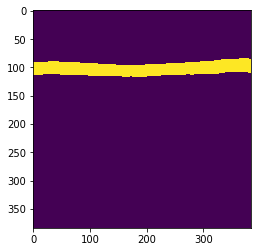

In [34]:
plt.imshow(mask)

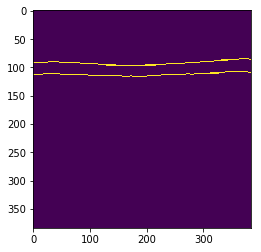

In [35]:
plt.imshow(border)

In [0]:
y_train.append(1 - np.sum(np.concatenate(y_train, axis=3), axis=3, keepdims=True))
y_train = np.concatenate(y_train, axis=3)

In [0]:
np.save("./drive/My Drive/Rosneft Seismic/train/y_train.npy", y_train)

In [15]:
np.all(y_train.sum(axis=3) == 1)

True

In [0]:
a[:, :, :, 7] = 1 - np.sum(a[:, :, :, :7], axis=3)

In [24]:
set(a.flatten())

{0.0, 1.0}

In [17]:
y_train_0 = load_data("./drive/My Drive/Rosneft Seismic/train/answer/0/", [f"inline_{s}.png" for s in range(3160, 3160 + 512)])

100%|██████████| 512/512 [02:52<00:00,  4.86it/s]


In [16]:
x_train.shape

(512, 384, 384, 1, 4)

In [18]:
y_train_0.shape

(512, 384, 384, 1)

In [0]:
import numpy as np
from PIL import Image

In [0]:
img = np.array(Image.open("./drive/My Drive/Rosneft Seismic/train/answer/0/inline_3160.png"))

In [31]:
set(img.flatten())

{0, 255}

### Склад

In [0]:
from dice_metric import dice, dice_border, dice_coef, dice_coef_loss
from uresnet_v3 import *
from load_data import load_train

[1, 10, 2, 3, 4, 5]

In [0]:
from google.colab import drive
drive.mount('/content/drive')

#from keras.models import Model
#from keras import backend as K
#from keras.callbacks import ModelCheckpoint

#from keras.optimizers import Adam
#from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, BatchNormalization, Add
#from keras.layers.core import Activation

#import numpy as np
#from numpy import genfromtxt
#from numpy.testing import assert_allclose
#from scipy import misc
#import matplotlib.pyplot as plt

#import os
#import sys
#from PIL import Image
#from tqdm import tqdm

sys.path.insert(1, 'drive/My Drive/Rosneft Seismic/models/modules')

from dice_metric import dice, dice_border, dice_coef, dice_coef_loss
from uresnet_v3 import *
from load_data import load_train



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
K.set_image_data_format('channels_last')

NB_EPOCH = 40
BATCH_SIZE = 1
VERBOSE = 1
VALIDATION_SPLIT = 0.2
OPTIMIZER = Adam()
IMG_ROWS, IMG_COLS, IMG_CHANNELS = 384, 384, 1
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, IMG_CHANNELS)


x_train, y_train = load_train('0')

  0%|          | 0/512 [00:00<?, ?it/s]

LOAD TRAIN DATA


100%|██████████| 512/512 [05:02<00:00,  2.12it/s]


END LOAD TRAIN DATA
STAR PREPROCCECING
END PREPROCCECING


In [0]:
model = uresnet(Conv2D_34skipblock, IMG_ROWS, IMG_COLS, IMG_CHANNELS)

model_checkpoint = ModelCheckpoint('weights_layer_0_v1.h5', monitor='val_loss', save_best_only=True)
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NB_EPOCH, verbose=VERBOSE, 
                    shuffle=True, validation_split=VALIDATION_SPLIT, callbacks=[model_checkpoint])

plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('TRAIN RESULT')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.grid()
plt.rcParams["figure.figsize"] = [100,100]
plt.show()

ValueError: ignored